In [75]:
# ─── Cell 1: Imports & Pretrained Model Setup ─────────────────────────────────
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import pandas as pd
from datasets import Dataset as HFDataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
import json
import cv2
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from spellchecker import SpellChecker


image 1/1 C:\Users\user\Downloads\dataset\test\Bulletin_de_soin\5246--6555004--20230914_page_0.jpg: 448x640 18 manuscrits, 93.8ms
Speed: 5.5ms preprocess, 93.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Résultat sauvegardé sous : detection_result.jpg


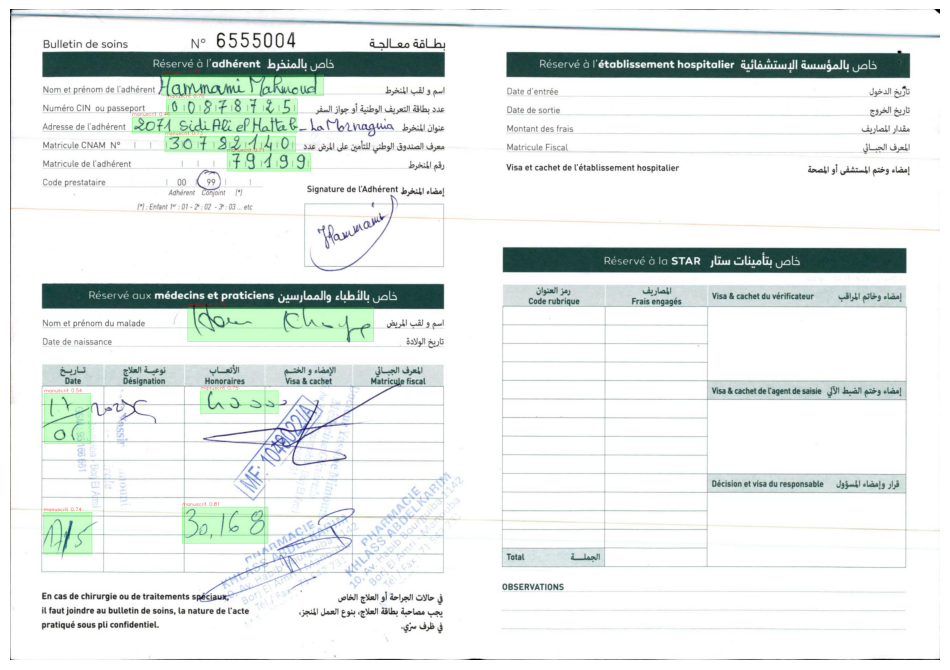

In [11]:

# Charger le modèle YOLOv8
yolo_model = YOLO(r"C:\Users\user\Downloads\train6\weights\best.pt")

# Charger l'image
image_path =  r"C:\Users\user\Downloads\dataset\test\Bulletin_de_soin\5246--6555004--20230914_page_0.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Conversion pour Matplotlib

# Détection avec un seuil de confiance bas
results = yolo_model(image_path, conf=0.05)

# Paramètres personnalisés pour les boîtes
box_alpha = 0.2  # Transparence du remplissage
line_width = 1    # Épaisseur des contours
font_scale = 0.6  # Taille du texte
text_color = (255, 0, 0)  # Couleur du texte (bleu)
box_color = (0, 255, 0)   # Couleur des boîtes (vert)

# Créer une copie pour l'annotation
annotated_image = image.copy()
# Extraire les coordonnées, scores et classes
boxes = []
scores = []
classes = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        boxes.append([x1, y1, x2 - x1, y2 - y1])  # Format [x, y, w, h]
        scores.append(float(box.conf[0]))
        classes.append(int(box.cls))

# Paramètres NMS
nms_threshold = 0.4  # Ajustable
confidence_threshold = 0.3  # Ne garder que les détections pertinentes

# Appliquer NMS
indices = cv2.dnn.NMSBoxes(boxes, scores, confidence_threshold, nms_threshold)
indices = [i[0] if isinstance(i, (list, tuple, np.ndarray)) else i for i in indices]

# Annoter l’image uniquement avec les boîtes gardées
annotated_image = image.copy()

for i in indices:
    x, y, w, h = boxes[i]
    x2, y2 = x + w, y + h
    label = f"{result.names[classes[i]]} {scores[i]:.2f}"

    overlay = annotated_image.copy()
    cv2.rectangle(overlay, (x, y), (x2, y2), box_color, -1)
    annotated_image = cv2.addWeighted(overlay, box_alpha, annotated_image, 1 - box_alpha, 0)
    cv2.rectangle(annotated_image, (x, y), (x2, y2), box_color, line_width)
    cv2.putText(annotated_image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, 1)


# Affichage
plt.figure(figsize=(12, 10))
plt.imshow(annotated_image)
plt.axis("off")

# Enregistrer le résultat si besoin
output_path = "detection_result.jpg"
cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
print(f"Résultat sauvegardé sous : {output_path}")

plt.show()

In [ ]:
trocr_model1 = VisionEncoderDecoderModel.from_pretrained("./trocr-large-finetuned")
trocr_processor1 = TrOCRProcessor.from_pretrained("./trocr-large-finetuned")

In [20]:
trocr_model2 = VisionEncoderDecoderModel.from_pretrained("./TrOCR Model")
trocr_processor2 = TrOCRProcessor.from_pretrained("./TrOCR Model", use_fast=False)

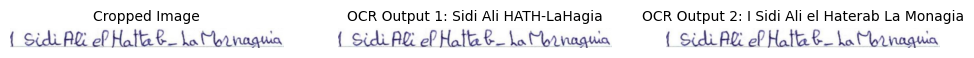

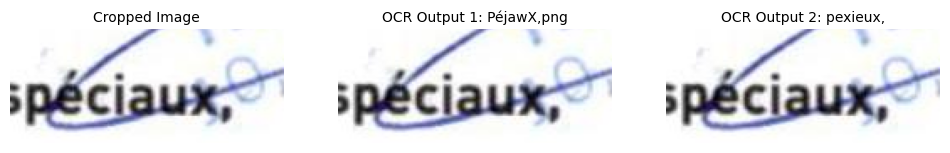

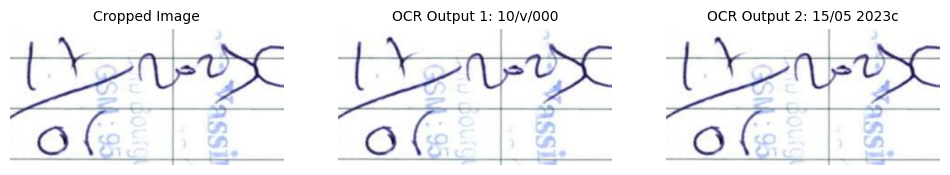

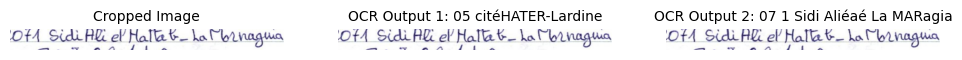

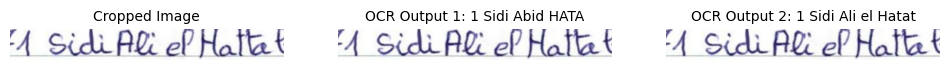

In [40]:
for result in results:
    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image_pil = Image.fromarray(image)  # Convert image to PIL for cropping
        cropped = image_pil.crop((x1, y1, x2, y2))

        if np.array(cropped).size == 0:
            continue

        # Prepare inputs for the first model (trocr_model1)
        inputs1 = trocr_processor1(images=cropped, return_tensors="pt").pixel_values
        inputs1 = inputs1.to(trocr_model1.device)

        with torch.no_grad():
            output1 = trocr_model1.generate(inputs1)

        text1 = trocr_processor1.batch_decode(output1, skip_special_tokens=True)[0]
        text1 = text1.strip() if text1.strip() != "" else "No text detected"

        # Prepare inputs for the second model (trocr_model2)
        inputs2 = trocr_processor2(images=cropped, return_tensors="pt").pixel_values
        inputs2 = inputs2.to(trocr_model2.device)

        with torch.no_grad():
            output2 = trocr_model2.generate(inputs2)

        text2 = trocr_processor2.batch_decode(output2, skip_special_tokens=True)[0]
        text2 = text2.strip() if text2.strip() != "" else "No text detected"

        # Display OCR outputs from both models
        plt.figure(figsize=(12, 6))

        # Show the cropped image
        plt.subplot(1, 3, 1)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title("Cropped Image", fontsize=10)

        # Show OCR output from the first model
        plt.subplot(1, 3, 2)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output 1: {text1}", fontsize=10)

        # Show OCR output from the second model
        plt.subplot(1, 3, 3)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output 2: {text2}", fontsize=10)

        plt.show()

In [59]:
correction_model_path = "C:/Users/user/Downloads/label_correction_model"
correction_tokenizer = T5Tokenizer.from_pretrained(correction_model_path, use_fast=False)
correction_model = AutoModelForSeq2SeqLM.from_pretrained(correction_model_path)

C:\Users\user\.conda\envs\GPU\lib\site-packages\transformers\models\t5\modeling_t5.py:530: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  scores = torch.matmul(
C:\Users\user\.conda\envs\GPU\lib\site-packages\transformers\models\t5\modeling_t5.py:571: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicA

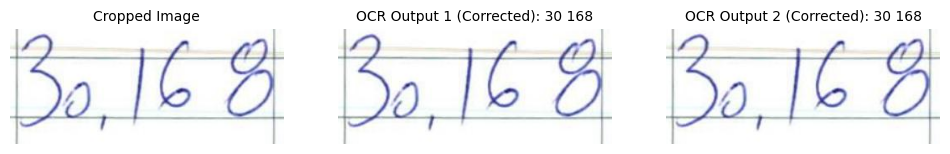

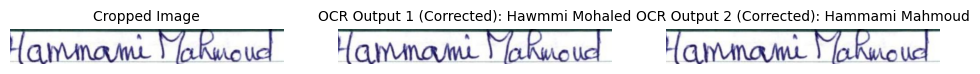

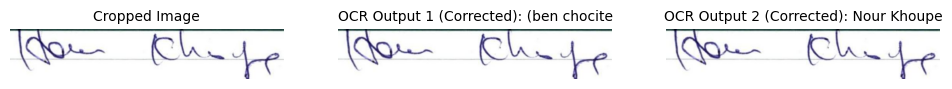

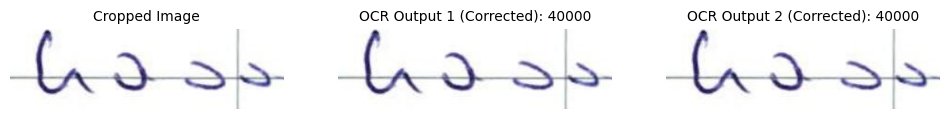

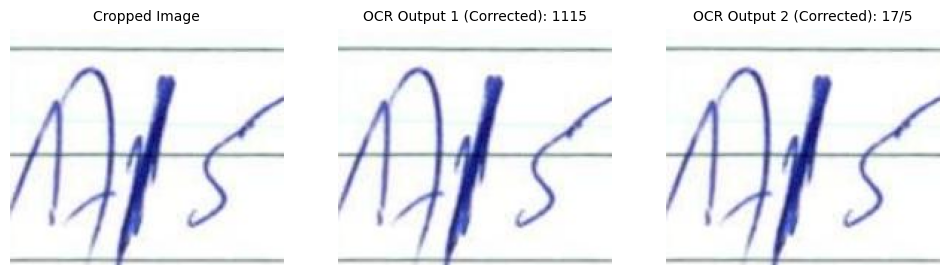

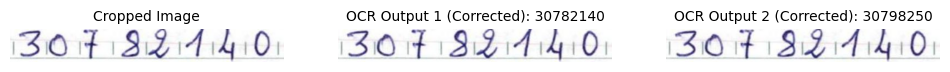

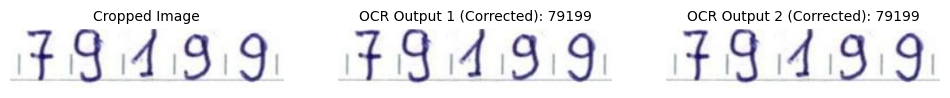

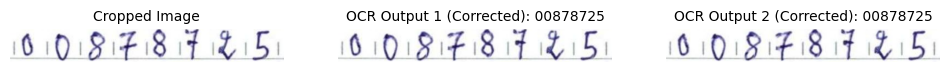

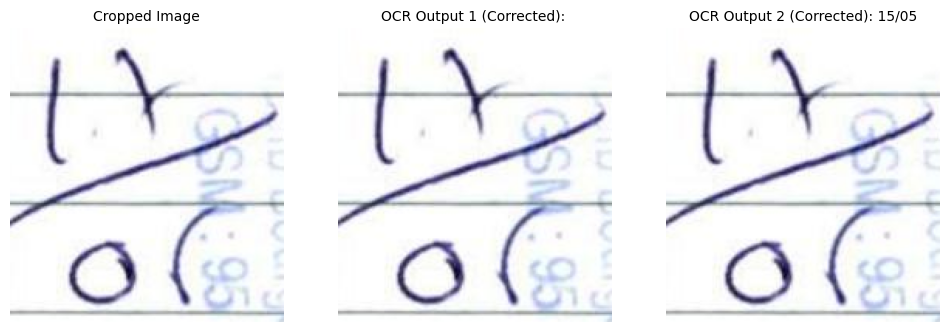

KeyboardInterrupt: 

In [64]:
# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
correction_model = correction_model.to(device)

# Now for the OCR and correction process
for result in results:
    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image_pil = Image.fromarray(image)
        cropped = image_pil.crop((x1, y1, x2, y2))

        if np.array(cropped).size == 0:
            continue

        # OCR with Model 1
        inputs1 = trocr_processor1(images=cropped, return_tensors="pt").pixel_values.to(device)
        with torch.no_grad():
            output1 = trocr_model1.generate(inputs1)
        text1 = trocr_processor1.batch_decode(output1, skip_special_tokens=True)[0].strip() or "No text detected"

        # OCR with Model 2
        inputs2 = trocr_processor2(images=cropped, return_tensors="pt").pixel_values.to(device)
        with torch.no_grad():
            output2 = trocr_model2.generate(inputs2)
        text2 = trocr_processor2.batch_decode(output2, skip_special_tokens=True)[0].strip() or "No text detected"

        # Correction step using the T5 model
        corrected_input1 = correction_tokenizer(text1, return_tensors="pt", padding=True).to(device)
        corrected_input2 = correction_tokenizer(text2, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            corrected_output1 = correction_model.generate(**corrected_input1)
            corrected_output2 = correction_model.generate(**corrected_input2)

        corrected_text1 = correction_tokenizer.batch_decode(corrected_output1, skip_special_tokens=True)[0].strip()
        corrected_text2 = correction_tokenizer.batch_decode(corrected_output2, skip_special_tokens=True)[0].strip()

        # Visualization
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title("Cropped Image", fontsize=10)

        plt.subplot(1, 3, 2)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output 1 (Corrected): {corrected_text1}", fontsize=10)

        plt.subplot(1, 3, 3)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output 2 (Corrected): {corrected_text2}", fontsize=10)

        plt.show()

In [76]:
def best_preprocess(image_array):
    # Ensure it's in grayscale (if not already)
    if len(image_array.shape) == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Resize for better resolution
    image = cv2.resize(image_array, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(image, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 31, 10)

    # Denoising and morphology
    denoised = cv2.fastNlMeansDenoising(thresh, h=30)
    kernel = np.ones((2, 2), np.uint8)
    morph = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, kernel)

    # Convert back to RGB for TrOCR
    return Image.fromarray(cv2.cvtColor(morph, cv2.COLOR_GRAY2RGB))


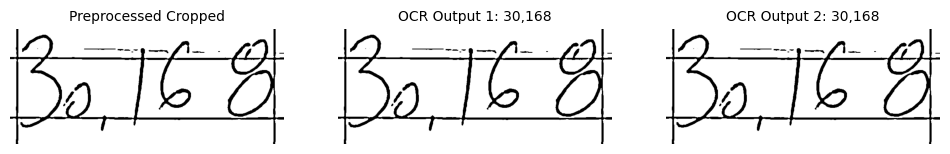

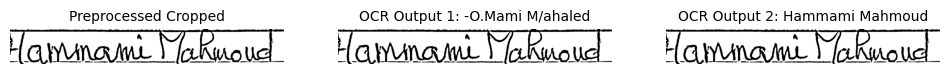

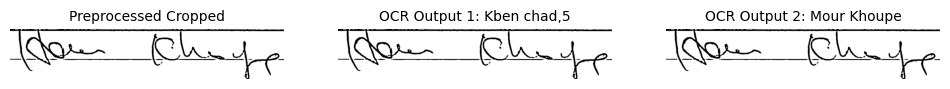

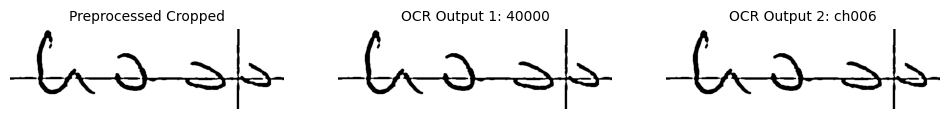

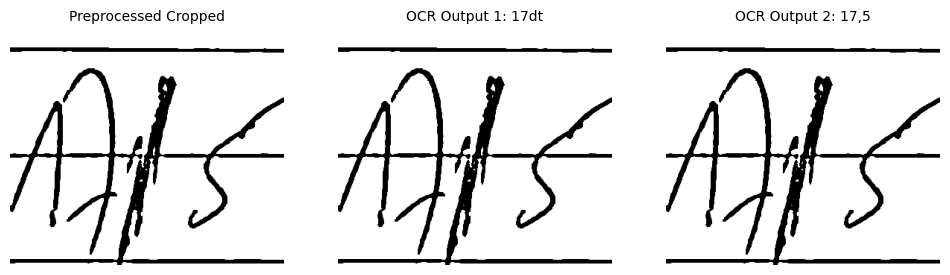

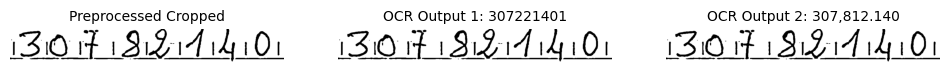

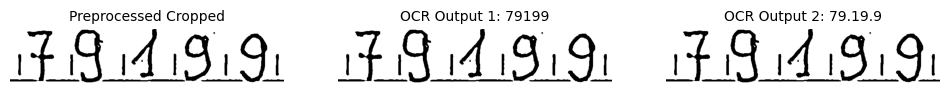

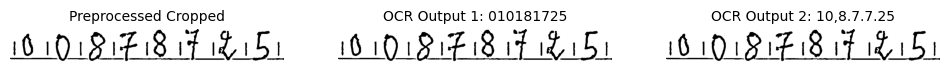

KeyboardInterrupt: 

In [77]:
for result in results:
    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image_pil = Image.fromarray(image)  # Convert original image to PIL
        cropped = image_pil.crop((x1, y1, x2, y2))

        if np.array(cropped).size == 0:
            continue

        # Preprocess the cropped image
        preprocessed = best_preprocess(np.array(cropped))

        # Prepare inputs for the first model (trocr_model1)
        inputs1 = trocr_processor1(images=preprocessed, return_tensors="pt").pixel_values
        inputs1 = inputs1.to(trocr_model1.device)

        with torch.no_grad():
            output1 = trocr_model1.generate(inputs1)

        text1 = trocr_processor1.batch_decode(output1, skip_special_tokens=True)[0]
        text1 = text1.strip() if text1.strip() != "" else "No text detected"

        # Prepare inputs for the second model (trocr_model2)
        inputs2 = trocr_processor2(images=preprocessed, return_tensors="pt").pixel_values
        inputs2 = inputs2.to(trocr_model2.device)

        with torch.no_grad():
            output2 = trocr_model2.generate(inputs2)

        text2 = trocr_processor2.batch_decode(output2, skip_special_tokens=True)[0]
        text2 = text2.strip() if text2.strip() != "" else "No text detected"

        # Display OCR outputs from both models
        plt.figure(figsize=(12, 6))

        # Show the preprocessed cropped image
        plt.subplot(1, 3, 1)
        plt.imshow(preprocessed, cmap='gray')
        plt.axis("off")
        plt.title("Preprocessed Cropped", fontsize=10)

        # Show OCR output from the first model
        plt.subplot(1, 3, 2)
        plt.imshow(preprocessed, cmap='gray')
        plt.axis("off")
        plt.title(f"OCR Output 1: {text1}", fontsize=10)

        # Show OCR output from the second model
        plt.subplot(1, 3, 3)
        plt.imshow(preprocessed, cmap='gray')
        plt.axis("off")
        plt.title(f"OCR Output 2: {text2}", fontsize=10)

        plt.show()


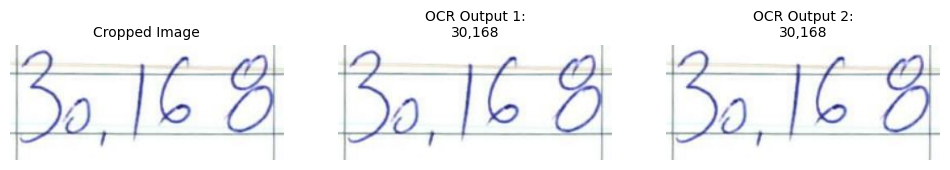

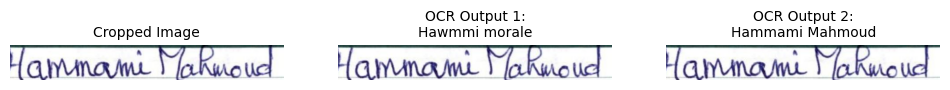

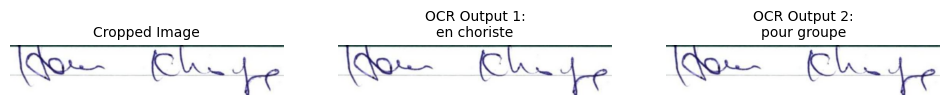

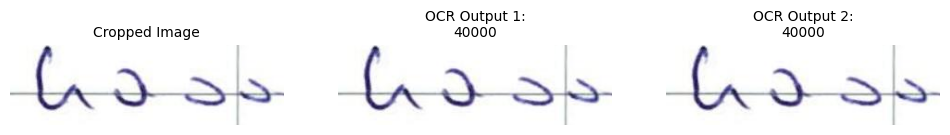

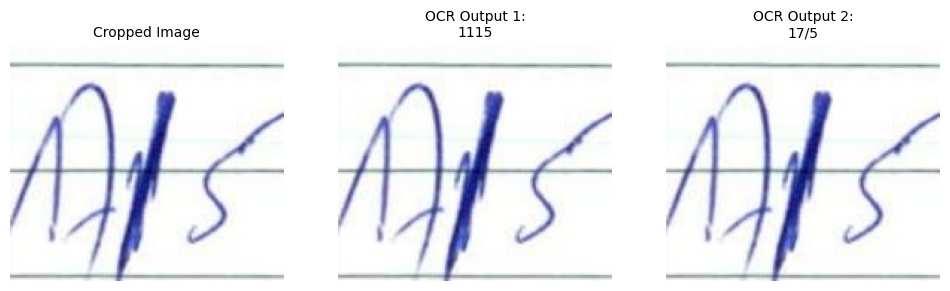

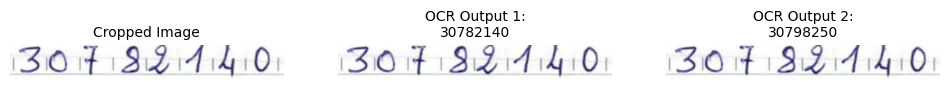

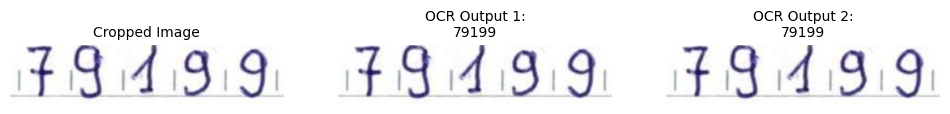

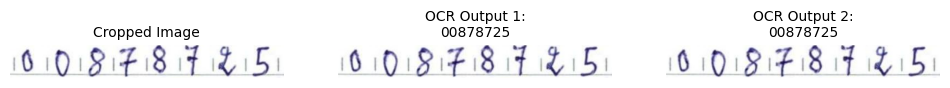

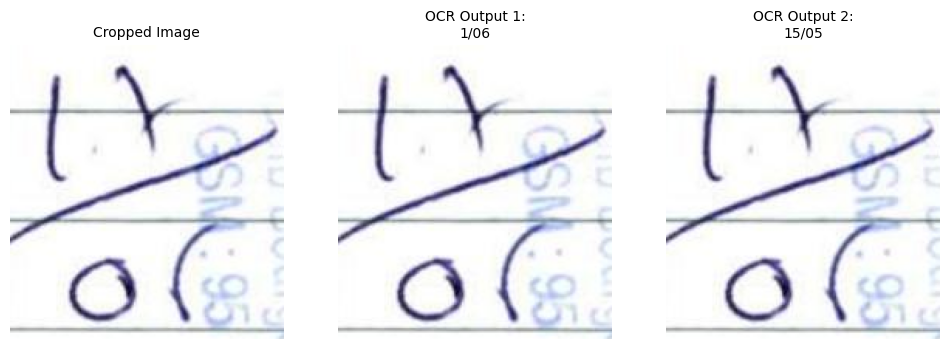

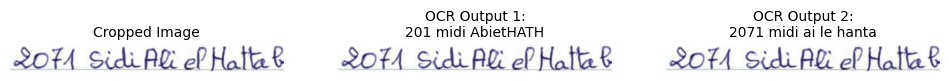

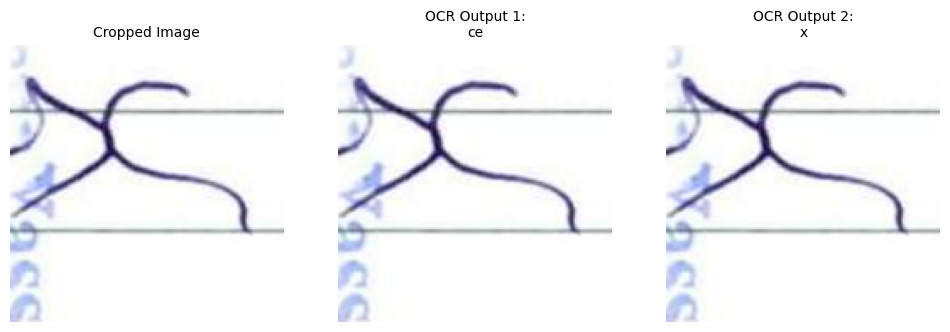

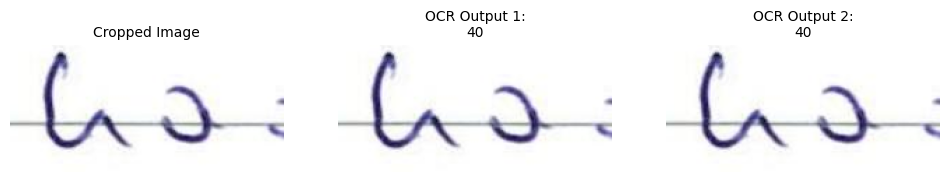

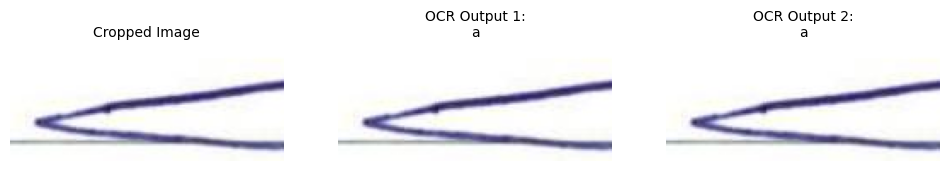

In [ ]:
from spellchecker import SpellChecker

def correct_french(text):
    corrected_words = []
    for word in text.split():
        correction = spell.correction(word)
        corrected_words.append(correction if correction is not None else word)
    return ' '.join(corrected_words)

# Loop through results and correct both OCR outputs
for result in results:
    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image_pil = Image.fromarray(image)  # Convert image to PIL for cropping
        cropped = image_pil.crop((x1, y1, x2, y2))

        if np.array(cropped).size == 0:
            continue

        # --- OCR Output 1 ---
        inputs1 = trocr_processor1(images=cropped, return_tensors="pt").pixel_values.to(trocr_model1.device)
        with torch.no_grad():
            output1 = trocr_model1.generate(inputs1)
        text1 = trocr_processor1.batch_decode(output1, skip_special_tokens=True)[0].strip()
        text1 = text1 if text1 != "" else "No text detected"
        text1_corrected = correct_french(text1)

        # --- OCR Output 2 ---
        inputs2 = trocr_processor2(images=cropped, return_tensors="pt").pixel_values.to(trocr_model2.device)
        with torch.no_grad():
            output2 = trocr_model2.generate(inputs2)
        text2 = trocr_processor2.batch_decode(output2, skip_special_tokens=True)[0].strip()
        text2 = text2 if text2 != "" else "No text detected"
        text2_corrected = correct_french(text2)

        # --- Display Results ---
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title("Cropped Image", fontsize=10)

        plt.subplot(1, 3, 2)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output 1:\n{text1_corrected}", fontsize=10)

        plt.subplot(1, 3, 3)
        plt.imshow(cropped)
        plt.axis("off")
        plt.title(f"OCR Output 2:\n{text2_corrected}", fontsize=10)

        plt.show()